In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from dataset import create_image_path_ds, preprocess_image
from Resnet50 import ResNet50


In [3]:
# def create_ds():
#   positive_train_1 = create_image_path_ds(f'./train_same.txt','./lfw/faces_png/')
#   negative_train_1 = create_image_path_ds(f'./train_diff.txt','./lfw/faces_png/')
#   positive_test_1 = create_image_path_ds(f'./test_same.txt','./lfw/faces_png/')
#   negative_test_1 = create_image_path_ds(f'./test_diff.txt','./lfw/faces_png/')
#   train_ds = positive_train_1.concatenate(negative_train_1)
#   val_ds = positive_test_1.concatenate(negative_test_1)
#   return train_ds, val_ds
def create_ds(i):
    positive_train_1 = create_image_path_ds(f'./lfw/lists/0{i}_train_same.txt','./lfw/faces_png/')
    negative_train_1 = create_image_path_ds(f'./lfw/lists/0{i}_train_diff.txt','./lfw/faces_png/')
    positive_test_1 = create_image_path_ds(f'./lfw/lists/0{i}_test_same.txt','./lfw/faces_png/')
    negative_test_1 = create_image_path_ds(f'./lfw/lists/0{i}_test_diff.txt','./lfw/faces_png/')
    train_ds = positive_train_1.concatenate(negative_train_1)
    val_ds = positive_test_1.concatenate(negative_test_1)
    return train_ds, val_ds


In [4]:
# train_ds, val_ds = create_ds()
train_ds, val_ds = create_ds(1)
for i in range(2,10):
  train_ds_1, val_ds_1 = create_ds(i)
  train_ds = train_ds.concatenate(train_ds_1)
  val_ds = val_ds.concatenate(val_ds_1)


In [5]:
for i,j,k in train_ds.take(1):
  print(i,j,k)

tf.Tensor(b'./lfw/faces_png/Abdullah_Gul_0001.png', shape=(), dtype=string) tf.Tensor(b'./lfw/faces_png/Abdullah_Gul_0006.png', shape=(), dtype=string) tf.Tensor(1.0, shape=(), dtype=float32)


In [6]:
rescale = Sequential([
    layers.Normalization(mean=0, variance=1)
])

In [7]:
IMG_SIZE = 96

def process(ds):
  ds = ds.map(lambda x1, x2, y: (preprocess_image(x1, (IMG_SIZE, IMG_SIZE)), preprocess_image(x2, (IMG_SIZE, IMG_SIZE)), y))
  ds = ds.map(lambda x1, x2, y: (rescale(x1), rescale(x2), y))
  return ds

train_ds = process(train_ds)
val_ds = process(val_ds)

In [8]:
train_ds = train_ds.shuffle(buffer_size=1024)
train_ds.element_spec

(TensorSpec(shape=(96, 96, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(96, 96, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [9]:
train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)


In [10]:
train_ds = train_ds.map(lambda x1,x2,y: ((x1,x2),y))
val_ds = val_ds.map(lambda x1,x2,y: ((x1,x2),y))

In [11]:
from tensorflow.keras.models import Model

res50 = ResNet50((IMG_SIZE,IMG_SIZE, 3), 2)

embedding = Sequential([
    Model(inputs=res50.input, outputs=res50.layers[-6].output, name='res50_extractor'),
    layers.Dense(512, activation='relu', name='fc_rd1'),
    layers.BatchNormalization(name= 'fc_db_rd1'),
    layers.Dense(128, activation='relu', name='fc_rd2'),
    layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)),
])
embedding.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res50_extractor (Functiona  (None, 8192)              23587712  
 l)                                                              
                                                                 
 fc_rd1 (Dense)              (None, 512)               4194816   
                                                                 
 fc_db_rd1 (BatchNormalizat  (None, 512)               2048      
 ion)                                                            
                                                                 
 fc_rd2 (Dense)              (None, 128)               65664     
                                                                 
 lambda (Lambda)             (None, 128)               0         
                                                                 
Total params: 27850240 (106.24 MB)
Trainable params: 2

In [12]:
@tf.keras.saving.register_keras_serializable()
class L1Dist(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
    def call(self, anchor_embedding, validation_embedding):
        return tf.math.abs(anchor_embedding - validation_embedding)


In [13]:
anchor_input = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3), name='anchor_input')
validation_input = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3), name='validation_input')


l1_layer = L1Dist(name='l1_distance')
distances = l1_layer(embedding(anchor_input), embedding(validation_input))
output_layer = layers.Dense(1, activation='sigmoid', name='fc2')(distances)

model = Model(inputs=[anchor_input, validation_input], outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor_input (InputLayer)   [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 validation_input (InputLay  [(None, 96, 96, 3)]          0         []                            
 er)                                                                                              
                                                                                                  
 sequential_1 (Sequential)   (None, 128)                  2785024   ['anchor_input[0][0]',        
                                                          0          'validation_input[0][0]']    
                                                                                              

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [15]:
# checkpoint.restore(tf.train.latest_checkpoint('/tmp/training_checkpoints_lfw'))

In [16]:
# model = tf.keras.models.load_model('siamese_lfw_1.keras')

In [ ]:
import gc
epochs = 5
# train(train_ds, epochs)
checkpoint = tf.train.Checkpoint(model)

for i in range(2):
  save_path = checkpoint.save('./tmp/training_checkpoints_lfw')
  gc.collect()
  print(save_path)
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=128
  )

In [26]:
model.save('siamese_lfw_2.keras')

In [35]:
test_ds = create_image_path_ds('./test_same.txt','./lfw/faces_png/').concatenate(create_image_path_ds('./test_diff.txt', './lfw/faces_png/'))
test_ds = process(test_ds)
test_ds = test_ds.batch(128)
test_ds = test_ds.map(lambda x1,x2,y: ((x1,x2),y))
model.evaluate(test_ds)

79/79 [==============================] - 14s 169ms/step - loss: 0.5379 - accuracy: 0.6783


[0.5378656983375549, 0.6783000230789185]

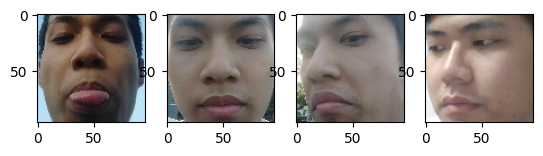

1/1 [==============================] - 0s 48ms/step
(1,2),[[0.73057127]]
1/1 [==============================] - 0s 38ms/step
(1,3),[[0.17986226]]
1/1 [==============================] - 0s 41ms/step
(1,4),[[0.56931245]]
1/1 [==============================] - 0s 69ms/step
(2,3),[[0.388373]]
1/1 [==============================] - 0s 46ms/step
(2,4),[[0.31620148]]
1/1 [==============================] - 0s 47ms/step
(3,4),[[0.910887]]


In [77]:
img_a = preprocess_image('mat_hieu3.jpg',(IMG_SIZE, IMG_SIZE))
img_b = preprocess_image('mat_hieu1.jpg',(IMG_SIZE, IMG_SIZE))
img_c = preprocess_image('mat_hieu2.jpg',(IMG_SIZE, IMG_SIZE))
img_d = preprocess_image('trung3.jpg',(IMG_SIZE, IMG_SIZE))

imgs = [np.expand_dims(preprocess_image(f'trung{i}.jpg',(IMG_SIZE, IMG_SIZE)), axis=0) for i in range(1,16)]

i_a = np.expand_dims(img_a, axis=0)
i_b = np.expand_dims(img_b, axis=0)
i_c = np.expand_dims(img_c, axis=0)
i_d = np.expand_dims(img_d, axis=0)

plt.subplot(1,4,1)
plt.imshow(img_a)
plt.subplot(1,4,2)
plt.imshow(img_b)
plt.subplot(1,4,3)
plt.imshow(img_c)
plt.subplot(1,4,4)
plt.imshow(img_d)
plt.show()


print(f'(1,2),{model.predict([i_a, i_b])}')
print(f'(1,3),{model.predict([i_a, i_c])}')
print(f'(1,4),{model.predict([i_a, i_d])}')
print(f'(2,3),{model.predict([i_b, i_c])}')
print(f'(2,4),{model.predict([i_b, i_d])}')
print(f'(3,4),{model.predict([i_c, i_d])}')




In [46]:
print(tf.__version__)

2.15.0
